In [2]:
print(spark)

In [4]:
moviesdf = spark.read.parquet("/home/venkyuser/movielens_processed/movies")
moviesdf.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- is_adult: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- original_language: string (nullable = true)
 |-- title: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: float (nullable = true)



In [5]:
print(str(moviesdf.count()))

45261


In [7]:
genredf = spark.read.json("/home/venkyuser/movielens_processed/genre")
genredf.show()

+--------+--------------------+
|genre_id|          genre_name|
+--------+--------------------+
|      16|           Animation|
|    6308|U.S. Office of Wa...|
|      28|              Action|
|      80|               Crime|
|    9648|             Mystery|
|      36|             History|
|   11176|Carousel Productions|
|   10752|                 War|
|    8424|         Fides Films|
|   18012|  Pulser Productions|
|      12|           Adventure|
|   29812|Telescene Film Gr...|
|    7760|           BROSTA TV|
|      53|            Thriller|
|    2957|         Double Play|
|    7105|   Mwana Productions|
|   18013|         Rogue State|
|   17161|       Odyssey Media|
|      37|             Western|
|   10769|             Foreign|
+--------+--------------------+
only showing top 20 rows



In [8]:
movie_genre = spark.read.json("/home/venkyuser/movielens_processed/movie_genre")
movie_genre.show()

+--------+--------+
|genre_id|movie_id|
+--------+--------+
|      16|     862|
|      35|     862|
|   10751|     862|
|      12|    8844|
|      14|    8844|
|   10751|    8844|
|   10749|   15602|
|      35|   15602|
|      35|   31357|
|      18|   31357|
|   10749|   31357|
|      35|   11862|
|      28|     949|
|      80|     949|
|      18|     949|
|      53|     949|
|      35|   11860|
|   10749|   11860|
|      28|   45325|
|      12|   45325|
+--------+--------+
only showing top 20 rows



In [9]:
movie_genre_df = movie_genre.join(genredf, movie_genre.genre_id == genredf.genre_id).join(moviesdf, moviesdf.movie_id == movie_genre.movie_id)
movie_genre_df.printSchema()

root
 |-- genre_id: long (nullable = true)
 |-- movie_id: long (nullable = true)
 |-- genre_id: long (nullable = true)
 |-- genre_name: string (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- is_adult: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- original_language: string (nullable = true)
 |-- title: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- release_date: date (nullable = true)
 |-- revenue: long (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- vote_average: float (nullable = true)



<AxesSubplot:xlabel='genre_name'>

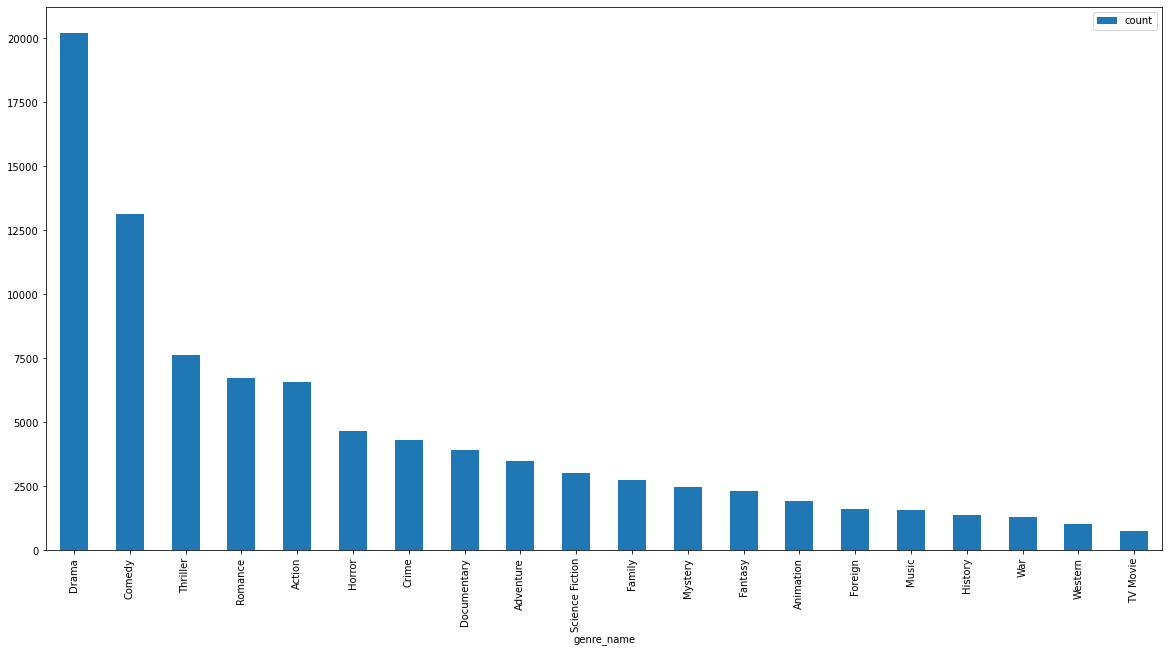

In [35]:
from pyspark.sql.functions import col
import pandas as pd

# Converting the spark data fram to a pandas dataframe to allow us to plot some charts.

movies_by_genre = movie_genre_df.groupby(movie_genre_df.genre_name).count().sort(col("count").desc())
movies_by_genre_pandas = movies_by_genre.toPandas()
movies_by_genre_pandas.plot.bar(x='genre_name',y='count', figsize=(20,10))

<AxesSubplot:xlabel='collection_name'>

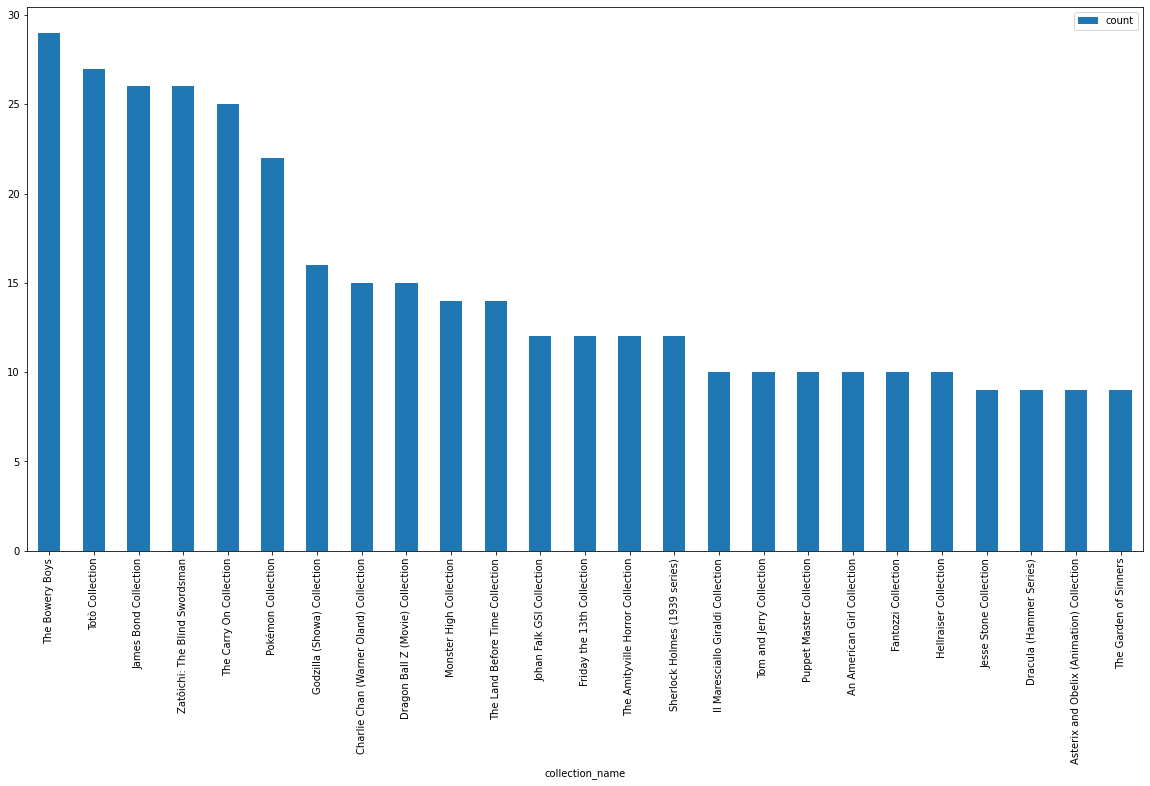

In [34]:
# Collections based analysis
movie_collection = spark.read.parquet("/home/venkyuser/movielens_processed/movie_collection")
collection = spark.read.parquet("/home/venkyuser/movielens_processed/collections")
movie_collection_collection = movie_collection.join(collection, movie_collection.collection_id == collection.collection_id)
movie_with_collection_df = moviesdf.join(movie_collection_collection, moviesdf.movie_id == movie_collection_collection.movie_id)
movie_with_collection_grouped = movie_with_collection_df.groupby("collection_name").count()
movie_with_collection_grouped_pd = movie_with_collection_grouped.sort(col("count").desc()).toPandas()
movie_with_collection_grouped_pd.head(25).plot.bar(x = 'collection_name', y = 'count', figsize=(20,10))

<AxesSubplot:xlabel='crew_name'>

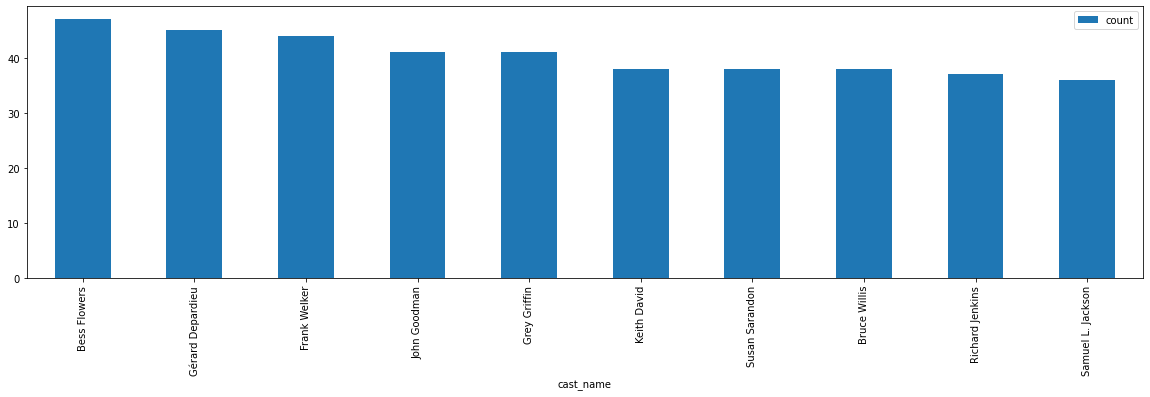

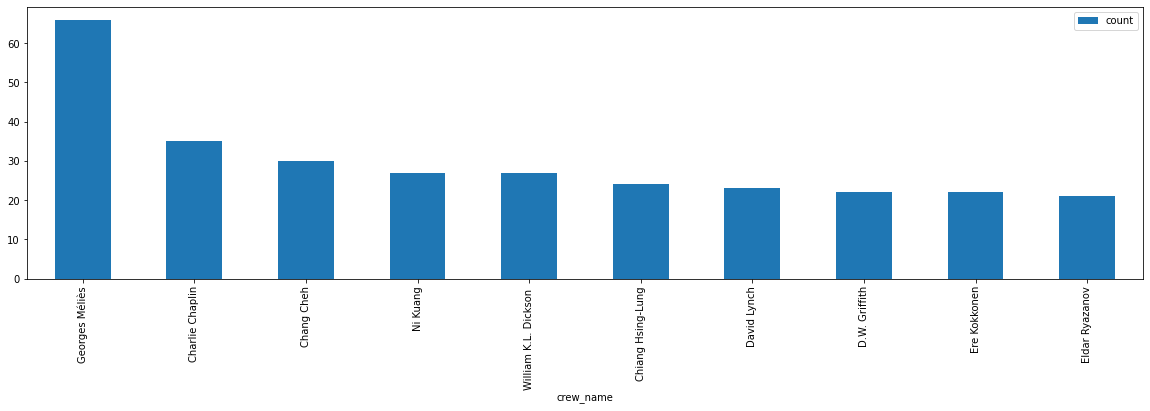

In [46]:
## Let us get the top 10 cast and crew and how many movies they have worked in.
cast = spark.read.parquet("/home/venkyuser/movielens_processed/cast").select("movie_id","cast_name")
crew = spark.read.parquet("/home/venkyuser/movielens_processed/crew").select("movie_id", "crew_name")
movies_with_cast = moviesdf.join(cast, moviesdf.movie_id == cast.movie_id)
movies_with_crew = moviesdf.join(crew, moviesdf.movie_id == crew.movie_id)
movies_with_cast_pd = movies_with_cast.groupBy("cast_name").count().orderBy(col("count").desc()).toPandas()
movies_with_cast_pd.head(10).plot.bar(x = 'cast_name', y = 'count', figsize=(20,5))
movies_with_crew_pd = movies_with_crew.groupBy("crew_name").count().orderBy(col("count").desc()).toPandas()
movies_with_crew_pd.head(10).plot.bar(x = 'crew_name', y = 'count', figsize=(20,5))

In [68]:
movie_keywords = spark.read.parquet("/home/venkyuser/movielens_processed/movie_keywords")
keywords = spark.read.parquet("/home/venkyuser/movielens_processed/keywords")
movie_keywords = movie_keywords.join(keywords, movie_keywords.keyword_id == keywords.keyword_id)
movie_keywords_genre = movie_keywords.join(movie_genre, movie_keywords.movie_id == movie_genre.movie_id)
movie_keywords_genre = movie_keywords_genre.select("keyword", "genre_id").join(genredf, movie_keywords_genre.genre_id == genredf.genre_id)
movie_keywords_genre = movie_keywords_genre.groupBy("genre_name", "keyword").count().dropDuplicates().orderBy(col("genre_name"), col("count").desc())
#movie_keywords_genre.show()
## We have to use window functions to get the top 1 rows of each group.
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
windowGenre = Window.partitionBy("genre_name").orderBy(col("count").desc())
movie_keywords_genre_top1 = movie_keywords_genre.withColumn("rowpos", row_number().over(windowGenre)).filter(col("rowpos") == 1 )
movie_keywords_genre_top1.orderBy("genre_name").show(30)
print(str(movie_keywords_genre_top1.count()))

+---------------+-----------------+-----+------+
|     genre_name|          keyword|count|rowpos|
+---------------+-----------------+-----+------+
|         Action|     martial arts|  289|     1|
|      Adventure|           sequel|  110|     1|
|      Animation|            anime|  131|     1|
|         Comedy|   woman director|  790|     1|
|          Crime|           murder|  429|     1|
|    Documentary|   woman director|  637|     1|
|          Drama|   woman director| 1599|     1|
|         Family|   woman director|  178|     1|
|        Fantasy|            magic|  136|     1|
|        Foreign|   woman director|  129|     1|
|        History|        biography|  130|     1|
|         Horror|           murder|  442|     1|
|          Music|          musical|  325|     1|
|        Mystery|           murder|  300|     1|
|        Romance|   woman director|  590|     1|
|Science Fiction|            alien|  258|     1|
|       TV Movie|        christmas|   49|     1|
|       Thriller|   

20


In [78]:
movie_spoken_lang = spark.read.parquet("/home/venkyuser/movielens_processed/movie_spoken_lang")
movie_spoken_lang.groupBy(col("spoken_language_id")).count().orderBy(col("count").desc()).show()

+------------------+-----+
|spoken_language_id|count|
+------------------+-----+
|                en|26338|
|                fr| 3805|
|                de| 2372|
|                es| 2214|
|                it| 2167|
|                ja| 1590|
|                ru| 1399|
|                zh|  704|
|                hi|  672|
|                pt|  553|
|                sv|  522|
|                ko|  498|
|                pl|  438|
|                cn|  418|
|                fi|  348|
|                hu|  331|
|                nl|  320|
|                ar|  313|
|                xx|  294|
|                da|  275|
+------------------+-----+
only showing top 20 rows



In [90]:
movie_production_countries = spark.read.parquet("/home/venkyuser/movielens_processed/movie_production_country")
production_countries = spark.read.parquet("/home/venkyuser/movielens_processed/production_country")
production_countries = movie_production_countries.join(production_countries, movie_production_countries.production_country_id == production_countries.production_country_id)
production_countries = production_countries.join(movie_genre, production_countries.movie_id == movie_genre.movie_id).drop("movie_id", "production_country_id")
production_countries = production_countries.join(genredf, genredf.genre_id == production_countries.genre_id).drop("genre_id")
production_countries.groupBy("production_country_name").count().orderBy(col("count").desc()).show()

+-----------------------+-----+
|production_country_name|count|
+-----------------------+-----+
|   United States of ...|42969|
|         United Kingdom| 8592|
|                 France| 6992|
|                Germany| 4265|
|                  Italy| 3723|
|                 Canada| 3599|
|                  Japan| 3564|
|                  India| 1847|
|                  Spain| 1727|
|                 Russia| 1663|
|              Hong Kong| 1337|
|              Australia| 1253|
|            South Korea| 1072|
|                 Sweden|  989|
|                Belgium|  795|
|                  China|  779|
|                Denmark|  699|
|            Netherlands|  656|
|                 Mexico|  649|
|                Finland|  604|
+-----------------------+-----+
only showing top 20 rows



<AxesSubplot:xlabel='year'>

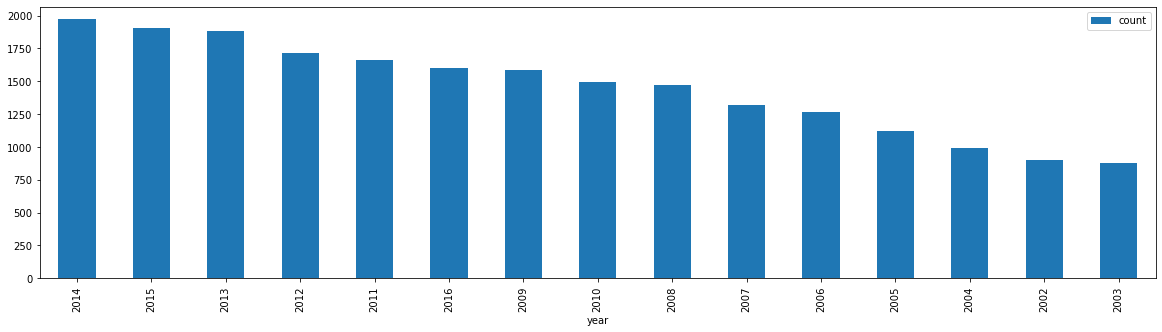

In [105]:
from pyspark.sql.functions import year
movie_count_by_year_pd = moviesdf.groupBy(year(col("release_date"))).count().orderBy(col("count").desc()).withColumnRenamed("year(release_date)","year").toPandas()
movie_count_by_year_pd.head(15).plot.bar(x = "year", y = "count", figsize=(20,5))